In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

- The text of a tweet
- A keyword from that tweet (although this may be blank!)
- The location the tweet was sent from (may also be blank)

## What am I predicting?

- You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

## Columns
- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (may be blank)
- keyword - a particular keyword from the tweet (may be blank)
- target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [20]:
train = pd.read_csv('NLP_disaster/train.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
test = pd.read_csv('NLP_disaster/test.csv')
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [4]:
submission = pd.read_csv('NLP_disaster/sample_submission.csv')
submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [5]:
pd.set_option('display.width', None)
print(train)

         id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...       1  
7610  M1.94 [01:04 UT

# Simple example

In [6]:
simple_train = ['call you tonight', 'Call me a cab', 'Please call me... PLEASE!']

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [8]:
vect.fit(simple_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [9]:
vect.get_feature_names()

['cab', 'call', 'me', 'please', 'tonight', 'you']

1. 문서 단어 행렬(Document-Term Matrix, DTM)의 표기법
- 문서 단어 행렬(Document-Term Matrix, DTM)이란 다수의 문서에서 등장하는 각 단어들의 빈도를 행렬로 표현한 것을 말합니다. 쉽게 생각하면 각 문서에 대한 BoW를 하나의 행렬로 만든 것으로 생각할 수 있으며, BoW와 다른 표현 방법이 아니라 BoW 표현을 다수의 문서에 대해서 행렬로 표현하고 부르는 용어입니다. 예를 들어서 이렇게 4개의 문서가 있다고 합시다.

In [11]:
# transform training data into a 'document-term matrix'
simple_train_dtm = vect.transform(simple_train)
simple_train_dtm

<3x6 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [12]:
simple_train_dtm.toarray()

array([[0, 1, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 0],
       [0, 1, 1, 2, 0, 0]], dtype=int64)

In [13]:
example = pd.DataFrame(simple_train_dtm.toarray(), columns=vect.get_feature_names())
example

,cab,call,me,please,tonight,you
0,0,1,0,0,1,1
1,1,1,1,0,0,0
2,0,1,1,2,0,0


In [17]:
# example text for model testing
simple_test = ["please don't call me"]

simple_test_dtm = vect.transform(simple_test)
simple_test_dtm.toarray()

array([[0, 1, 1, 1, 0, 0]], dtype=int64)

In [18]:
pd.DataFrame(simple_test_dtm.toarray(), columns=vect.get_feature_names())

,cab,call,me,please,tonight,you
0,0,1,1,1,0,0


- vect.fit(열차)는 훈련 데이터의 어휘를 학습한다.

- vect.usage(열차)는 적합한 어휘를 사용하여 교육 데이터로부터 문서 용어 매트릭스를 작성한다.

- vect.properties(test)는 적합 어휘를 사용하여 테스트 데이터로부터 문서 용어 매트릭스를 작성한다(그리고 이전에 보지 못한 토큰은 무시함).

# 1. Data

In [21]:
train.dropna(how="any", inplace=True, axis=1)

train.columns = ['id', 'message', 'label']
train.head()

,id,message,label
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


# 2. Exploratory Data Analysis (EDA)

In [22]:
train.describe()

,id,label
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [26]:
train.groupby('label').describe()

id                                                           \
        count         mean          std   min      25%     50%     75%   
label                                                                    
0      4342.0  5276.446338  3157.206802  23.0  2513.25  5243.5  8038.5   
1      3271.0  5661.608071  3097.094809   1.0  3104.50  5676.0  8252.0   

                
           max  
label           
0      10848.0  
1      10873.0

In [27]:
train['message_len'] = train.message.apply(len)
train

,id,message,label,message_len
0,1,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,Forest fire near La Ronge Sask. Canada,1,38
2,5,All residents asked to 'shelter in place' are ...,1,133
3,6,"13,000 people receive #wildfires evacuation or...",1,65
4,7,Just got sent this photo from Ruby #Alaska as ...,1,88
...,...,...,...,...
7608,10869,Two giant cranes holding a bridge collapse int...,1,83
7609,10870,@aria_ahrary @TheTawniest The out of control w...,1,125
7610,10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65
7611,10872,Police investigating after an e-bike collided ...,1,137


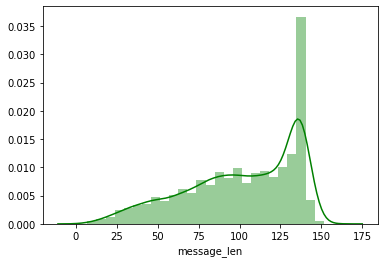

In [30]:
sns.distplot(train['message_len'], color="green")

In [31]:
train[train['label'] == 1].describe()

,id,label,message_len
count,3271.000000,3271.0,3271.000000
mean,5661.608071,1.0,108.113421
std,3097.094809,0.0,29.309854
min,1.000000,1.0,14.000000
25%,3104.500000,1.0,88.000000
50%,5676.000000,1.0,115.000000
75%,8252.000000,1.0,136.000000
max,10873.000000,1.0,151.000000


In [32]:
train[train['label'] == 0].describe()

,id,label,message_len
count,4342.000000,4342.0,4342.000000
mean,5276.446338,0.0,95.706817
std,3157.206802,0.0,35.885924
min,23.000000,0.0,7.000000
25%,2513.250000,0.0,68.000000
50%,5243.500000,0.0,101.000000
75%,8038.500000,0.0,130.000000
max,10848.000000,0.0,157.000000


In [43]:
# True Max
train[train['message_len'] == 151]['message']

614    @CAgov If 90BLKs&amp;8WHTs colluded 2 take WHT F @USAgov AUTH Hostage&amp;2 make her look BLK w/Bioterrorism&amp;use her lgl/org IDis ID still hers?@VP
Name: message, dtype: object

In [44]:
train[train['message_len'] == 157]['message']

1270    when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned??????????????????????????????????????????????????
Name: message, dtype: object

#  3. Text Pre-processing

## NLTK 라이브러리를 활용 -> 
1. 구두점 제거
2. stopword 제거
3. 정리된 clean text 반환

In [45]:
import string
from nltk.corpus import stopwords

In [147]:
def text_process(texts) :
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure', '','Û','Ò']
    
    punc = [char for char in texts if char not in string.punctuation]
    
    punc = ''.join(punc)
    
    return ' '.join(
        [word for word in punc.split() if word.lower() not in STOPWORDS])

In [148]:
train['clean'] = train['message'].apply(text_process)
train

,id,message,label,message_len,clean
0,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,69,Deeds Reason earthquake May ALLAH Forgive us
1,4,Forest fire near La Ronge Sask. Canada,1,38,Forest fire near La Ronge Sask Canada
2,5,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,133,residents asked shelter place notified officers evacuation shelter place orders expected
3,6,"13,000 people receive #wildfires evacuation orders in California",1,65,13000 people receive wildfires evacuation orders California
4,7,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,88,got sent photo Ruby Alaska smoke wildfires pours school
...,...,...,...,...,...
7608,10869,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1,83,Two giant cranes holding bridge collapse nearby homes httptcoSTfMbbZFB5
7609,10870,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1,125,ariaahrary TheTawniest control wild fires California even Northern part state troubling
7610,10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1,65,M194 0104 UTC5km Volcano Hawaii httptcozDtoyd8EbJ
7611,10872,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1,137,Police investigating ebike collided car Little Portugal Ebike rider suffered serious nonlife threatening injuries


In [149]:
train[train['message_len'] == 157]['clean'] 
#제대로 clean 되었음

1270    youre taking shower someone flushes toilet 1 second GTFO get burned
Name: clean, dtype: object

In [150]:
from collections import Counter

words = train[train.label== 1]['clean'].apply(lambda x: [word.lower() for word in x.split()])
disaster_words = Counter()

for msg in words:
    disaster_words.update(msg)
    
print(disaster_words.most_common(50))

[('fire', 178), ('news', 136), ('via', 121), ('disaster', 117), ('california', 111), ('suicide', 110), ('police', 107), ('amp', 106), ('people', 105), ('killed', 93), ('like', 92), ('hiroshima', 86), ('storm', 85), ('crash', 84), ('fires', 84), ('us', 81), ('families', 81), ('train', 79), ('emergency', 76), ('buildings', 75), ('bomb', 74), ('two', 71), ('mh370', 71), ('nuclear', 70), ('attack', 69), ('video', 69), ('wildfire', 69), ('get', 66), ('accident', 66), ('bombing', 66), ('one', 65), ('northern', 64), ('burning', 64), ('dead', 63), ('pm', 62), ('legionnaires', 62), ('bomber', 60), ('homes', 58), ('car', 57), ('still', 57), ('war', 57), ('new', 56), ('atomic', 56), ('obama', 54), ('fatal', 54), ('years', 53), ('collapse', 51), ('may', 50), ('forest', 50), ('debris', 50)]


In [151]:
words = train[train.label== 0]['clean'].apply(lambda x: [word.lower() for word in x.split()])
non_disaster_words = Counter()

for msg in words:
    non_disaster_words.update(msg)
    
print(non_disaster_words.most_common(50))

[('like', 253), ('amp', 192), ('new', 168), ('get', 163), ('one', 128), ('body', 112), ('via', 99), ('would', 97), ('video', 96), ('people', 91), ('love', 89), ('know', 85), ('back', 84), ('time', 83), ('us', 83), ('got', 83), ('see', 82), ('cant', 81), ('emergency', 81), ('full', 81), ('day', 78), ('youtube', 76), ('going', 75), ('still', 72), ('fire', 72), ('go', 67), ('want', 67), ('good', 67), ('think', 66), ('3', 64), ('man', 62), ('world', 62), ('lol', 61), ('rt', 60), ('life', 60), ('youre', 58), ('first', 58), ('news', 57), ('last', 56), ('burning', 56), ('really', 55), ('way', 55), ('need', 55), ('make', 54), ('work', 54), ('best', 53), ('let', 52), ('much', 51), ('many', 51), ('even', 51)]


# 4. 단어 벡터화(Vectorization) - check frequency

In [152]:
X = train.clean
y = train.label
print(X.shape)
print(y.shape)

(7613,)
(7613,)


In [153]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6090,)
(1523,)
(6090,)
(1523,)


In [154]:
# train 데이터 어휘 학습 후 문서 용어 매트릭스를 작성
X_train_dtm = vect.transform(X_train)
X_train_dtm

<6090x19076 sparse matrix of type '<class 'numpy.int64'>'
	with 58779 stored elements in Compressed Sparse Row format>

In [155]:
#동등하게 적합성과 변환을 한 단계로 결합
X_train_dtm = vect.fit_transform(X_train)
X_train_dtm

<6090x19076 sparse matrix of type '<class 'numpy.int64'>'
	with 58779 stored elements in Compressed Sparse Row format>

In [156]:
X_test_dtm = vect.transform(X_test)
X_test_dtm

<1523x19076 sparse matrix of type '<class 'numpy.int64'>'
	with 11274 stored elements in Compressed Sparse Row format>

## TF-IDF
- TF(단어 빈도, term frequency)는 특정한 단어가 문서 내에 얼마나 자주 등장하는지를 나타내는 값으로, 이 값이 높을수록 문서에서 중요하다고 생각할 수 있다. 하지만 단어 자체가 문서군 내에서 자주 사용되는 경우, 이것은 그 단어가 흔하게 등장한다는 것을 의미한다. 이것을 DF(문서 빈도, document frequency)라고 하며, 이 값의 역수를 IDF(역문서 빈도, inverse document frequency)라고 한다. TF-IDF는 TF와 IDF를 곱한 값이다.
- 
- IDF 값은 문서군의 성격에 따라 결정된다. 예를 들어 '원자'라는 낱말은 일반적인 문서들 사이에서는 잘 나오지 않기 때문에 IDF 값이 높아지고 문서의 핵심어가 될 수 있지만, 원자에 대한 문서를 모아놓은 문서군의 경우 이 낱말은 상투어가 되어 각 문서들을 세분화하여 구분할 수 있는 다른 낱말들이 높은 가중치를 얻게 된다.
- 
- 역문서 빈도(IDF)는 한 단어가 문서 집합 전체에서 얼마나 공통적으로 나타나는지를 나타내는 값이다. 전체 문서의 수를 해당 단어를 포함한 문서의 수로 나눈 뒤 로그를 취하여 얻을 수 있다.

In [157]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train_dtm)
tfidf_transformer.transform(X_train_dtm)

<6090x19076 sparse matrix of type '<class 'numpy.float64'>'
	with 58779 stored elements in Compressed Sparse Row format>

In [158]:
tfidf_transformer

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

# 4. Modeling
### MultinomialNB 사용. MultinomialNB = Naive bayes 중 하나.
### 각 특성을 개별로 취급해 파라미터를 학습하고 각 특성에서 클래스별 통계를 단순하게 취합
### ( GaussianNB, BernoulliNB, MultinomialNB )
- GaussianNB : 연속형 데이터
- BernoulliNB : 이진형
- MultinomialNB : 카운트 데이터(특성이 어떤 것을 헤아린 정수 카운트

In [159]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [160]:
nb.fit(X_train_dtm, y_train) #%time 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [161]:
y_pred = nb.predict(X_test_dtm)

In [162]:
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred)

0.7912015758371634

In [163]:
metrics.confusion_matrix(y_test, y_pred)

array([[747, 114],
       [204, 458]], dtype=int64)

In [164]:
# False prediction print
X_test[y_pred > y_test]

6587    Survivors Shanghai Ghetto reunite 70 years httptco1Ki8LgVAy4 Shanghai China                                 
6338    CLIP Topdown coercion structural weakness ensuring government failure httptcogNORIjnSVa                     
2293    Postal Service agrees sell demolish downtown building httptco7mEpKbF9E8                                     
2116    VIDEO Slain Mexican Journalist Unknowingly Predicted Death httptcoQxhOwCv16R via BreitbartNews              
5080    team ready natural disaster violent client power outage Contact Ready Vet design httptcou2NJPoR39K          
                                                       ...                                                          
7317    Man selling WILD MORELS Ambleside Farmr MartSunMUSHROOM forageSECRET KNOW TREES grow amp BEST FOREST FIRES  
2811    DISASTER AVERTED Police kill gunman Û÷hoax deviceÛª atåÊcinema httptco5NG0FzpVdS                          
3740    Save Date Saturday August 15 2015 Salisbury Fire Departm

In [165]:
X_test[y_pred < y_test]

3119    babies actually get electrocuted wall sockets wondering survived childhood                                   
4734    YoungHeroesID Lava Blast dan Power Red PantherAttack CunayyH TaufikCJ                                        
6923    OH GOD RYANS TROUBLE httptcoADIp0UnXHU                                                                       
775     anyone else see fireball falling earth Look like plane blew                                                  
3321    want everyone know Emilee worried getting milkshake supposed evacuate                                        
                                        ...                                                                          
2291    far right racist AvigdorLiberman calls destruction Susiya Previously also called beheadings httptcoLi8otXt8hh
6154    real question tornado siren going Dyersburg                                                                  
6047    MRW sinkhole opens beneath friends gif funny lol

In [166]:
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([0.09216596, 0.11609247, 0.06097199, ..., 0.99795286, 0.99972831,
       0.00132731])

In [167]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.8478715117319494

In [168]:
#pip install yellowbrick

C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


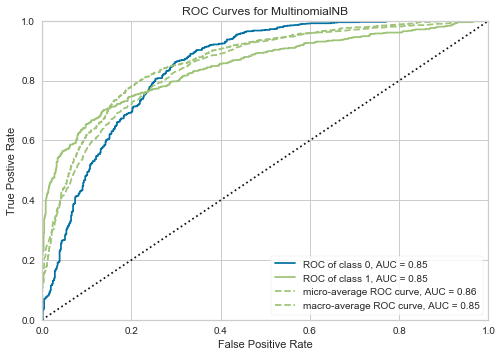

In [169]:
from yellowbrick.classifier import ROCAUC
from yellowbrick.datasets import load_spam

nbb = MultinomialNB()
nbb.fit(X_train_dtm, y_train)

visualizer = ROCAUC(nbb, classes=[0, 1])

visualizer.fit(X_train_dtm, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test_dtm, y_test)        # Evaluate the model on the test data
visualizer.show()         

# test

In [170]:
test.dropna(how="any", inplace=True, axis=1)
test.columns = ['id', 'message']
test.head()

ValueError: Length mismatch: Expected axis has 4 elements, new values have 2 elements

In [171]:
test['message_len'] = test.message.apply(len)
test

,id,message,message_len,clean
0,0,Just happened a terrible car crash,34,happened terrible car crash
1,2,"Heard about #earthquake is different cities, stay safe everyone.",64,Heard earthquake different cities stay safe everyone
2,3,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",96,forest fire spot pond geese fleeing across street cannot save
3,9,Apocalypse lighting. #Spokane #wildfires,40,Apocalypse lighting Spokane wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan,45,Typhoon Soudelor kills 28 China Taiwan
...,...,...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTENERS XrWn,55,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTENERS XrWn
3259,10865,Storm in RI worse than last hurricane. My city&amp;3others hardest hit. My yard looks like it was bombed. Around 20000K still without power,139,Storm RI worse last hurricane cityamp3others hardest hit yard looks like bombed Around 20000K still without power
3260,10868,Green Line derailment in Chicago http://t.co/UtbXLcBIuY,55,Green Line derailment Chicago httptcoUtbXLcBIuY
3261,10874,MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3,65,MEG issues Hazardous Weather Outlook HWO httptco3X6RBQJHn3


In [172]:
test['clean'] = test['message'].apply(text_process)
test

,id,message,message_len,clean
0,0,Just happened a terrible car crash,34,happened terrible car crash
1,2,"Heard about #earthquake is different cities, stay safe everyone.",64,Heard earthquake different cities stay safe everyone
2,3,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",96,forest fire spot pond geese fleeing across street cannot save
3,9,Apocalypse lighting. #Spokane #wildfires,40,Apocalypse lighting Spokane wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan,45,Typhoon Soudelor kills 28 China Taiwan
...,...,...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTENERS XrWn,55,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTENERS XrWn
3259,10865,Storm in RI worse than last hurricane. My city&amp;3others hardest hit. My yard looks like it was bombed. Around 20000K still without power,139,Storm RI worse last hurricane cityamp3others hardest hit yard looks like bombed Around 20000K still without power
3260,10868,Green Line derailment in Chicago http://t.co/UtbXLcBIuY,55,Green Line derailment Chicago httptcoUtbXLcBIuY
3261,10874,MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3,65,MEG issues Hazardous Weather Outlook HWO httptco3X6RBQJHn3


In [173]:
test.describe()

,id,message_len
count,3263.000000,3263.000000
mean,5427.152927,102.108183
std,3146.427221,33.972158
min,0.000000,5.000000
25%,2683.000000,78.000000
50%,5500.000000,109.000000
75%,8176.000000,134.000000
max,10875.000000,151.000000


In [146]:
test[test['message_len'] == 151]['message']

279    @HarvardU If 90BLKs&amp;8WHTs colluded 2 take WHT F @USAgov AUTH Hostage&amp;2 make her look BLK w/Bioterrorism&amp;use her lgl/org IDis ID still hers?
283    @GACourts If 90BLKs&amp;8WHTs colluded 2 take WHT F @USAgov AUTH Hostage&amp;2 make her look BLK w/Bioterrorism&amp;use her lgl/org IDis ID still hers?
534    3 rules for a long life.  #1ÛÒDonÛªt go in burning buildings! #2ÛÒDonÛªt jump out of perfectly good airplanes! #3ÛÒDonÛªt awaken sleeping giants!
Name: message, dtype: object

In [174]:
test['clean'] = test['message'].apply(text_process)
test

,id,message,message_len,clean
0,0,Just happened a terrible car crash,34,happened terrible car crash
1,2,"Heard about #earthquake is different cities, stay safe everyone.",64,Heard earthquake different cities stay safe everyone
2,3,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",96,forest fire spot pond geese fleeing across street cannot save
3,9,Apocalypse lighting. #Spokane #wildfires,40,Apocalypse lighting Spokane wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan,45,Typhoon Soudelor kills 28 China Taiwan
...,...,...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTENERS XrWn,55,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTENERS XrWn
3259,10865,Storm in RI worse than last hurricane. My city&amp;3others hardest hit. My yard looks like it was bombed. Around 20000K still without power,139,Storm RI worse last hurricane cityamp3others hardest hit yard looks like bombed Around 20000K still without power
3260,10868,Green Line derailment in Chicago http://t.co/UtbXLcBIuY,55,Green Line derailment Chicago httptcoUtbXLcBIuY
3261,10874,MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3,65,MEG issues Hazardous Weather Outlook HWO httptco3X6RBQJHn3


In [175]:
test[test['message_len'] == 151]['clean']

279    HarvardU 90BLKsamp8WHTs colluded take WHT F USAgov AUTH Hostageamp2 make look BLK wBioterrorismampuse lglorg IDis ID still     
283    GACourts 90BLKsamp8WHTs colluded take WHT F USAgov AUTH Hostageamp2 make look BLK wBioterrorismampuse lglorg IDis ID still     
534    3 rules long life 1ÛÒDonÛªt go burning buildings 2ÛÒDonÛªt jump perfectly good airplanes 3ÛÒDonÛªt awaken sleeping giants
Name: clean, dtype: object

In [178]:
test_dtm = vect.transform(test['clean'])
test_dtm

<3263x19076 sparse matrix of type '<class 'numpy.int64'>'
	with 24424 stored elements in Compressed Sparse Row format>

In [179]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(test_dtm)
tfidf_transformer.transform(test_dtm)

<3263x19076 sparse matrix of type '<class 'numpy.float64'>'
	with 24424 stored elements in Compressed Sparse Row format>

In [180]:
y_pred = nb.predict(test_dtm)

In [189]:
y_pred_prob = nb.predict_proba(test_dtm)[:, 1]
y_pred_prob

array([0.82479044, 0.74986114, 0.99538194, ..., 0.99066569, 0.99889834,
       0.99065561])

In [190]:
y_pred_prob.size

3263

# Submission

In [182]:
submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [185]:
y_pred_prob.size

1523

In [191]:
submission['target'] = y_pred_prob
submission

,id,target
0,0,0.824790
1,2,0.749861
2,3,0.995382
3,9,0.893315
4,11,0.999986
...,...,...
3258,10861,0.968913
3259,10865,0.902486
3260,10868,0.990666
3261,10874,0.998898


In [194]:
submission['target'] = submission['target'].apply(lambda x : 1 if x >= 0.85 else x)

In [195]:
submission

,id,target
0,0,0.824790
1,2,0.749861
2,3,1.000000
3,9,1.000000
4,11,1.000000
...,...,...
3258,10861,1.000000
3259,10865,1.000000
3260,10868,1.000000
3261,10874,1.000000


In [196]:
submission.to_csv('./sub1.csv', index=False)

In [198]:
s1 = pd.read_csv('sub1.csv')
s1

,Unnamed: 0,id,target
0,0,0,0.824790
1,1,2,0.749861
2,2,3,1.000000
3,3,9,1.000000
4,4,11,1.000000
...,...,...,...
3258,3258,10861,1.000000
3259,3259,10865,1.000000
3260,3260,10868,1.000000
3261,3261,10874,1.000000
